In [4]:
import csv
import json
import pickle
import os
import pandas as pd
from datasets import Dataset
from comparison_task import ComparisonTaskLLMBar
from datasets import load_dataset

In [ ]:
def dataset_to_list_of_dicts(url: str):
    """
    Converts a Hugging Face dataset into a list of dictionaries, where each dictionary represents a row.

    Args:
    url (str): The URL or path of the Hugging Face dataset.

    Returns:
    List[Dict]: A list of dictionaries, where each dictionary corresponds to a row in the dataset.
    """
    # Load the dataset
    dataset = load_dataset(url)

    # Assume 'train' split is available, modify as needed for other splits
    if 'train' in dataset:
        data_split = 'train'
    else:
        # Default to the first available split if 'train' is not present
        data_split = list(dataset.keys())[0]

    data_dict = dataset[data_split].to_dict()  # Convert to a dictionary of lists

    # Create a list of dictionaries, one for each row
    rows_as_dicts = [{column: data_dict[column][i] for column in data_dict} for i in range(len(data_dict[list(data_dict.keys())[0]]))]

    return rows_as_dicts

# Example usage
url = "llm-aes/hanna-annotated-latest"
data_list = dataset_to_list_of_dicts(url)
print(data_list[:5])  # Print the first few rows to verify


In [8]:
dataset = load_dataset("llm-aes/hanna-annotated-latest")
df = pd.DataFrame(dataset['train'])

In [11]:
print(df.head())

                                             premise  llm_label  \
0  A 4-D star collides with Earth, causing it to ...          0   
1  A 4-D star collides with Earth, causing it to ...          0   
2  A 4-D star collides with Earth, causing it to ...          0   
3  A 4-D star collides with Earth, causing it to ...          0   
4  A 4-D star collides with Earth, causing it to ...          0   

                      worker     generator_1 generator_2  human_label task  \
0       w_gpt-3.5-turbo-0125  BertGeneration        CTRL            0  t_0   
1  w_gemini-pro-rate-explain  BertGeneration        CTRL            0  t_0   
2    w_gemini-pro-score-only  BertGeneration        CTRL            0  t_0   
3      w_gpt3.5_rate_explain  BertGeneration        CTRL            0  t_0   
4  w_gemini-pro-analyze-rate  BertGeneration        CTRL            0  t_0   

   __index_level_0__  
0               1028  
1               1028  
2               1028  
3               6308  
4            

### Data Analysis for CPSC 571

In [2]:
from dataset_loader import DatasetLoader
import matplotlib.pyplot as plt

We will expore two datasets: HANNA and OpenMEVA-MANS (abbreviated as MEVA in this notebook). Both datasets include machine generated stories with scores assigned by humans. We will explore the MEVA dataset first and then the HANNA dataset.

In [27]:
writers = ["gpt", "plan_write", "s2s", "gpt_kg", "fusion"]
path = "meva/mans_wp.json"
loader = DatasetLoader("meva", path, writers)
prompt2Idx, idx2Prompt, prompt2Scores, prompt2Stories = loader.process_data()
print(len(prompt2Idx), len(idx2Prompt), len(prompt2Scores), len(prompt2Stories))

story_length = 0
num_stories = 0
for prompt in prompt2Stories:
    for writer in prompt2Stories[prompt]:
        num_stories += 1
        story = prompt2Stories[prompt][writer]
        story_length += len(story.split())

assert num_stories == 1000
ave_story_length = story_length / num_stories

print("Meva average story length: ", ave_story_length)

meva data loaded from local successfully.

200 200 200 200
Meva average story length:  229.115


In [28]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Display Random Samples
def display_random_samples(n=5):
    random_prompts = random.sample(list(prompt2Stories.keys()), n)
    for prompt in random_prompts:
        print(f"Prompt: {prompt}")
        for writer in writers:
            if writer in prompt2Stories[prompt]:
                print(f"  Writer: {writer}")
                print(f"    Score: {prompt2Scores[prompt].get(writer, 'N/A')/5}")
                print(f"    Story: {prompt2Stories[prompt][writer][:100]}...")  # Display first 100 chars
            else:
                print(f"  Writer: {writer} - No story")
        print("-" * 20)

# Summarize Scores
def summarize_scores():
    scores = [score for prompt in prompt2Scores for score in prompt2Scores[prompt].values()]
    print(f"Scores Summary:\n  Mean: {np.mean(scores)/5}\n  Median: {np.median(scores)/5}\n  Min: {min(scores)/5}\n  Max: {max(scores)/5}")

# Check for Missing Data
def check_for_missing_data():
    missing_stories = {prompt: [writer for writer in writers if writer not in prompt2Stories[prompt]] for prompt in prompt2Stories}
    print("Missing Stories Report:")
    for prompt, missing in missing_stories.items():
        if missing:
            print(f"  Prompt: {prompt} Missing Writers: {missing}")

# Visualize Score Distribution
def visualize_score_distribution():
    scores = [score for prompt in prompt2Scores for score in prompt2Scores[prompt].values()]
    scores = [score/5 for score in scores]  # Normalize scores
    plt.figure(figsize=(10, 6))
    plt.hist(scores, bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Story Scores (scores scaled to between 1 and 5)')
    plt.xlabel('Score')
    plt.ylabel('Number of Stories')
    plt.show()

Visualize 5 random prompts and all the stories and scores associated with these prompts (prompt, story, score). We have natural language data set, so the visualization is in terms of text.

In [29]:
display_random_samples()

Prompt: Write about the longest period of time that you 've spent trying to get a scrap of tape off of your body , in as serious a manner possible .
  Writer: gpt
    Score: 2.4
    Story: He , I am a sorry man . Where do you think you are ? Your papers are all barren and dewy . Your page...
  Writer: plan_write
    Score: 3.0
    Story: Hey and thought I was n't as any rule ! Happy . In this interview , your dumb friend calls to your q...
  Writer: s2s
    Score: 3.0
    Story: The ring clicked off the dashboard . A statement of things that spoke was empty , and working with p...
  Writer: gpt_kg
    Score: 3.0
    Story: I tried not to smile as I tape taped my face to the wall . I mean , with all the pain it was , it ma...
  Writer: fusion
    Score: 2.0
    Story: I had always been alone in this city . But now that I 've made this mistake , I think I 'd rather di...
--------------------
Prompt: Stuck
  Writer: gpt
    Score: 3.0
    Story: in a world of magical elves , you have succ

Summarize the scores in the dataset (each score scaled to between 1 and 5)

In [30]:
summarize_scores()

Scores Summary:
  Mean: 2.8112
  Median: 2.8
  Min: 1.0
  Max: 5.0


Visualize the score distribution

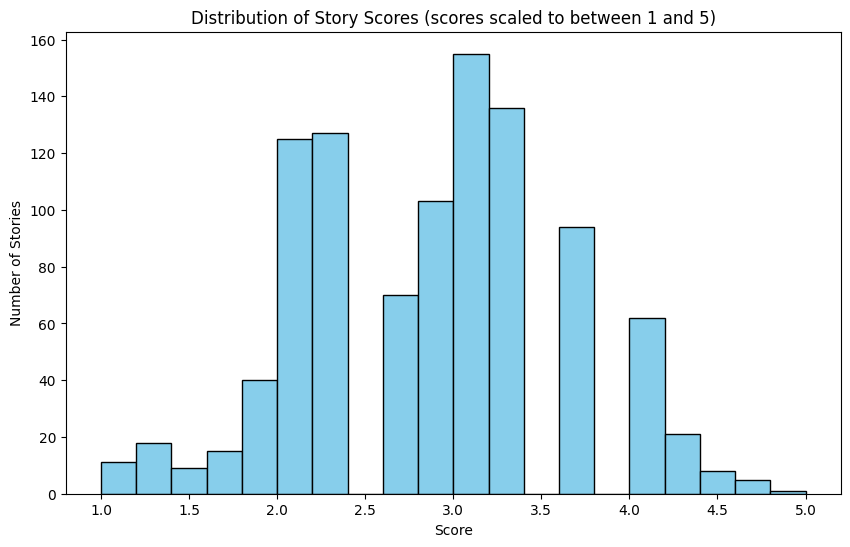

In [31]:
visualize_score_distribution()

From the preliminary analysis and visualization above, we can see that when scaled to between 1 and 5, most stories have a score around 3.0. The score distribution resembles a normal distribution. So in a sense most stories have close scores, so it may be hard for an automatic story evaluation system to differentiate stories of slightly different qualties in this dataset.

Stories of scores below 2.0 and above 4.0 have relatively few examples.

Below we plot the total scores over all generated stories scaled to between 1 and 5 for each story generator.

Meva max score:  25
Meva min score:  5 

Meva max score:  5.0
Meva min score:  1.0 

Meva average score for gpt: 3.111999999999999
Meva average score for plan_write: 2.5769999999999986
Meva average score for s2s: 2.484
Meva average score for gpt_kg: 3.1789999999999994
Meva average score for fusion: 2.704


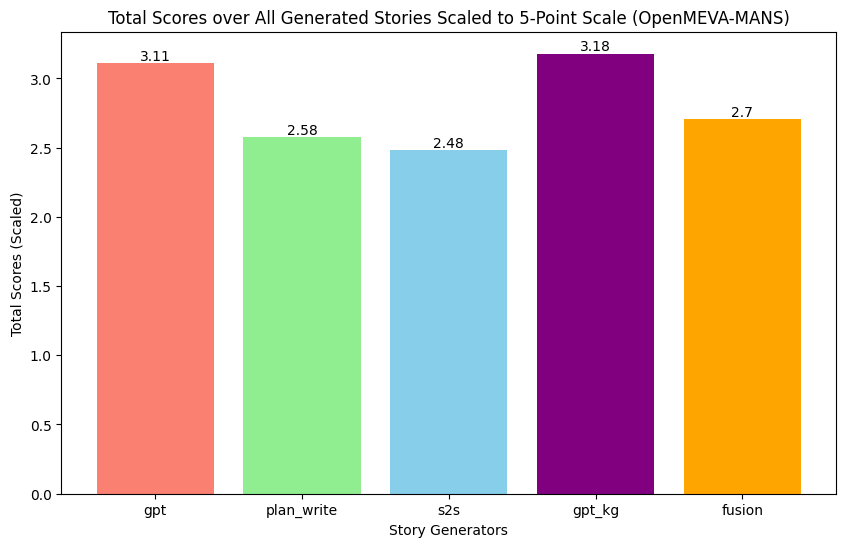

In [32]:
max_score = 0
min_score = 10000
for prompt in prompt2Stories:
    for writer in prompt2Stories[prompt]:
        score = prompt2Scores[prompt][writer]
        max_score = max(max_score, score)
        min_score = min(min_score, score)

print("Meva max score: ", max_score)
print("Meva min score: ", min_score, "\n")

max_score = 0
min_score = 10000
for prompt in prompt2Stories:
    for writer in writers:
        prompt2Scores[prompt][writer] /= 5
        score = prompt2Scores[prompt][writer]
        max_score = max(max_score, score)
        min_score = min(min_score, score)

print("Meva max score: ", max_score)
print("Meva min score: ", min_score, "\n")

writer_scores = {writer: 0 for writer in writers}
for writer in writers:
    for prompt in prompt2Scores:
        writer_scores[writer] += prompt2Scores[prompt][writer]
    assert len(prompt2Scores) == 200
    writer_scores[writer] /= len(prompt2Scores)

for writer in writers:
    print(f"Meva average score for {writer}: {writer_scores[writer]}")

# Plot the average scores per writer
scores = [writer_scores[writer] for writer in writers]

# Creating the bar graph
plt.figure(figsize=(10, 6))
colors = ['salmon', 'lightgreen', 'skyblue', 'purple', 'orange', 'gold', 'pink', 'lightgrey', 'cyan', 'olive']
bars = plt.bar(writers, scores, color=colors)

# Adding the numeric score on the corresponding bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Adding labels and title
plt.xlabel('Story Generators')
plt.ylabel('Total Scores (Scaled)')
plt.title('Total Scores over All Generated Stories Scaled to 5-Point Scale (OpenMEVA-MANS)')

# Display the plot
plt.show()

We can see that gpt_kg performs the best overall and s2s peforms the worst overall.

Now we move onto the HANNA dataset.

In [33]:
writers = ["Human", "BertGeneration", "CTRL", "GPT", "GPT-2 (tag)", "GPT-2", "RoBERTa", "XLNet", "Fusion", "HINT", "TD-VAE"]
path = "hanna/hanna_stories_annotations.csv"
loader = DatasetLoader("hanna", path, writers)
prompt2Idx, idx2Prompt, prompt2Scores, prompt2Stories = loader.process_data()
print(len(prompt2Idx), len(idx2Prompt), len(prompt2Scores), len(prompt2Stories))

writers = ["BertGeneration", "CTRL", "GPT", "GPT-2 (tag)", "GPT-2", "RoBERTa", "XLNet", "Fusion", "HINT", "TD-VAE"]
story_length = 0
num_stories = 0
for prompt in prompt2Stories:
    for writer in writers:
        num_stories += 1
        story = prompt2Stories[prompt][writer]
        story_length += len(story.split())

assert num_stories == 960
ave_story_length = story_length / num_stories

print("Hanna average story length: ", ave_story_length)

hanna data loaded from local successfully.

96 96 96 96
Hanna average story length:  228.740625


In [34]:
import random
import numpy as np
import matplotlib.pyplot as plt


# Display Random Samples
def display_random_samples_hanna(n=5):
    random_prompts = random.sample(list(prompt2Stories.keys()), n)
    for prompt in random_prompts:
        print(f"Prompt: {prompt}")
        for writer in writers:
            if writer in prompt2Stories[prompt]:
                print(f"  Writer: {writer}")
                print(f"    Score: {prompt2Scores[prompt].get(writer, 'N/A')/18}")
                print(f"    Story: {prompt2Stories[prompt][writer][:100]}...")  # Display first 100 chars
            else:
                print(f"  Writer: {writer} - No story")
        print("-" * 20)

# Summarize Scores
def summarize_scores_hanna():
    scores = [score for prompt in prompt2Scores for score in prompt2Scores[prompt].values()]
    print(f"Scores Summary:\n  Mean: {np.mean(scores)/18}\n  Median: {np.median(scores)/18}\n  Min: {min(scores)/18}\n  Max: {max(scores)/18}")

# Check for Missing Data
def check_for_missing_data_hanna():
    missing_stories = {prompt: [writer for writer in writers if writer not in prompt2Stories[prompt]] for prompt in prompt2Stories}
    print("Missing Stories Report:")
    for prompt, missing in missing_stories.items():
        if missing:
            print(f"  Prompt: {prompt} Missing Writers: {missing}")

# Visualize Score Distribution
def visualize_score_distribution_hanna():
    scores = [score for prompt in prompt2Scores for score in prompt2Scores[prompt].values()]
    scores = [score/18 for score in scores]  # Normalize scores
    plt.figure(figsize=(10, 6))
    plt.hist(scores, bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Story Scores (scores scaled to between 1 and 5)')
    plt.xlabel('Score')
    plt.ylabel('Number of Stories')
    plt.show()

We peform the same analyis on the HANNA dataset as on MEVA.

In [36]:
display_random_samples_hanna()

Prompt: Aliens come to Earth in hoping to wipe us out and take over the planet, but are honorable and gives us a fighting chance. They announce they will return in 100 years so as to give Earth a chance to prepare and defend itself. Neither side expected what the other would bring to war
  Writer: BertGeneration
    Score: 3.888888888888889
    Story: . Most of the sun was showered in projectiles from outside the Earth's atmosphere. Viscous asteroids...
  Writer: CTRL
    Score: 2.3333333333333335
    Story: “Sir, can we talk, it's getting late.” “Who is your king?” “Sir, is there something I could help you...
  Writer: GPT
    Score: 3.2222222222222223
    Story: with all the species on earth. the planet and earth were about to end in the pacific ocean, when the...
  Writer: GPT-2 (tag)
    Score: 4.111111111111111
    Story: The security forces had been hoarding resources for weeks and only one faction was left who seemed l...
  Writer: GPT-2
    Score: 2.0555555555555554
    Story: 

In [37]:
summarize_scores_hanna()

Scores Summary:
  Mean: 2.5507154882154883
  Median: 2.5
  Min: 1.0
  Max: 4.666666666666667


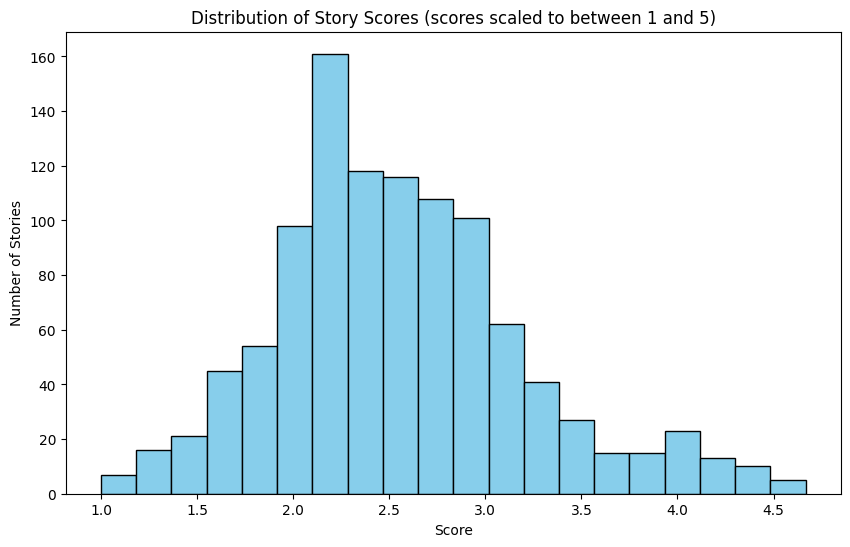

In [38]:
visualize_score_distribution_hanna()

We can see that the score distribuion of the HANNA dataset is different from that of MEVA. Compared to MEVA, the score distribution of HANNA has fewer gaps. But this distribution is still similar to that of MEVA in a sense that most stories have scores in the center portion within the [1, 5] range. This can make differentiating stories with different quality harder because their scores are not too spread out.

There are fewer stories with scores below 1.5 and above 4.0.

Hanna max score:  84
Hanna min score:  18 

Hanna max score:  4.166666666666667
Hanna min score:  1.0 

Hanna average score for BertGeneration: 2.5092592592592586
Hanna average score for CTRL: 2.4033564814814823
Hanna average score for GPT: 2.561342592592594
Hanna average score for GPT-2 (tag): 2.7309027777777786
Hanna average score for GPT-2: 2.719328703703704
Hanna average score for RoBERTa: 2.5497685185185195
Hanna average score for XLNet: 2.3576388888888897
Hanna average score for Fusion: 2.1429398148148144
Hanna average score for HINT: 1.8616898148148149
Hanna average score for TD-VAE: 2.4577546296296298


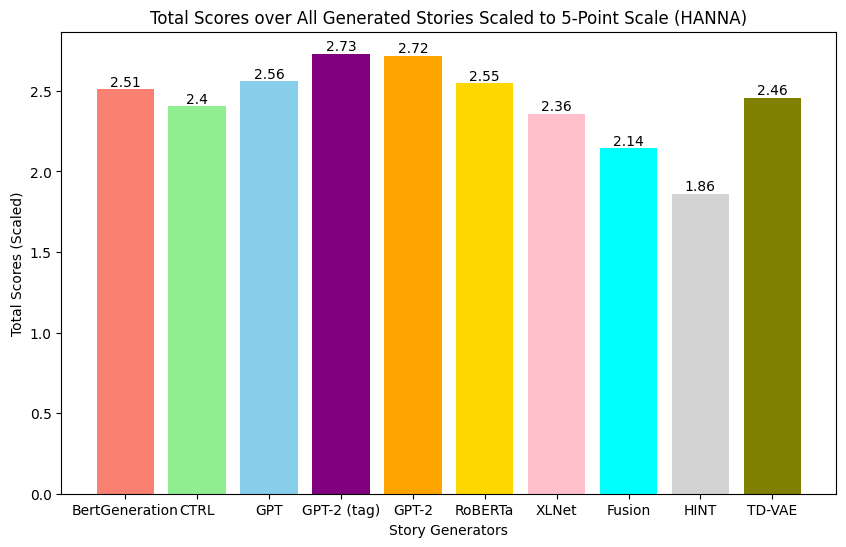

In [39]:
max_score = 0
min_score = 10000
for prompt in prompt2Stories:
    for writer in prompt2Stories[prompt]:
        score = prompt2Scores[prompt][writer]
        max_score = max(max_score, score)
        min_score = min(min_score, score)

print("Hanna max score: ", max_score)
print("Hanna min score: ", min_score, "\n")

max_score = 0
min_score = 10000
for prompt in prompt2Stories:
    for writer in writers:
        prompt2Scores[prompt][writer] /= 18
        score = prompt2Scores[prompt][writer]
        max_score = max(max_score, score)
        min_score = min(min_score, score)

print("Hanna max score: ", max_score)
print("Hanna min score: ", min_score, "\n")

writer_scores = {writer: 0 for writer in writers}
for writer in writers:
    for prompt in prompt2Scores:
        writer_scores[writer] += prompt2Scores[prompt][writer]
    assert len(prompt2Scores) == 96
    writer_scores[writer] /= len(prompt2Scores)

for writer in writers:
    print(f"Hanna average score for {writer}: {writer_scores[writer]}")

# Plot the average scores per writer
scores = [writer_scores[writer] for writer in writers]

# Creating the bar graph
plt.figure(figsize=(10, 6))
colors = ['salmon', 'lightgreen', 'skyblue', 'purple', 'orange', 'gold', 'pink', 'cyan', 'lightgrey', 'olive']
bars = plt.bar(writers, scores, color=colors)

# Adding the numeric score on the corresponding bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Adding labels and title
plt.xlabel('Story Generators')
plt.ylabel('Total Scores (Scaled)')
plt.title('Total Scores over All Generated Stories Scaled to 5-Point Scale (HANNA)')

# Display the plot
plt.show()

We can see that GPT-2 (tag) performs the best overall and HINT peforms the worst overall.